# Analyse and visualize grid search results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from tqdm import tqdm


import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import failure_probability_Nadaraya_Watson as fp

from sklearn.linear_model import LogisticRegression

from torch.utils.data import random_split
import torch

import importlib
importlib.reload(fp)

<module 'failure_probability_Nadaraya_Watson' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/failure_probability_Nadaraya_Watson.py'>

In [2]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(
        weather_path, index_col=["Date", "State"], parse_dates=["Date"],
        usecols=lambda c: c not in ["Unnamed: 0"]
    )
    power = pd.read_csv(
        powerload_path, index_col=["Date", "State"], parse_dates=["Date"],
        usecols=lambda c: c not in ["Unnamed: 0"]
    )
    base = list(weather.columns) + list(power.columns) + ["Season", "Month", "DayOfWeek", "DayOfYear", "Holiday", "Weekend"]
    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {"EventStartDT", "Date", "PRCP_30dz"}
    feats = [c for c in base if c not in drop]
    feats.sort()
    return feats

In [3]:
weather_data_file = '../DATA/weather_data_per_state_all.csv'
power_load_file = '../DATA/power_load_input.csv'
feature_names = load_feature_bases(weather_data_file, power_load_file)


data_df, feature_cols, target_cols = im.preprocess_data(
        failure_path="../DATA/filtered_events.csv",
        event_count_path="../DATA/event_count.csv",
        weather_data_path=weather_data_file,
        power_data_path=power_load_file,
        feature_names=feature_names,
        randomize=False,
        target='Frequency',
        state_one_hot=True,
        cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
        cause_code_n_clusters=1,
        feature_na_drop_threshold=0.10,
        sort_by_date=True,
    )

# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek",  "DayOfYear", "State"}
stand_cols = [f for f in feature_cols if  all([not f.startswith(exc) for exc in exclude])]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")
    

Dropping weather columns with >10.0% NaN: ['ADPT', 'ASLP', 'ASTP', 'AWND', 'EVAP', 'HeatIndex', 'RHAV', 'RHMN', 'RHMX', 'StormSeverity', 'THIC', 'TSUN', 'WESD', 'WESF', 'WSFG', 'WindChill']
Standardized features (21): ['CDD', 'CDD_7d', 'ExtremeCold', 'ExtremeHeat', 'ExtremeWind', 'FDD', 'FDD_7d', 'HDD', 'HDD_7d', 'PAVG', 'PDMAX', 'PMAX', 'PMIN', 'PRCP', 'PRCP_30d_sum', 'SNOW', 'SNWD', 'SnowSeverity', 'TAVG', 'TMAX', 'TMIN']


In [4]:
weather_data_file = '../DATA/weather_data_per_state_all.csv'
power_load_file = '../DATA/power_load_input.csv'
weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
power_load_data = pd.read_csv(power_load_file, index_col=[0,1], parse_dates=[0])


# features_names=['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMIN', 'TMAX', 'ASTP', 'AWND', 
#                 'PAVG', 'PMIN', 'PMAX', 'PDMAX',
#                 'Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(weather_data.columns) + list(power_load_data.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']
features_names = list(set(features_names)-set(['EventStartDT', 'Date']))


merged_count_df, feature_names, target_columns = im.preprocess_data(failure_path='../DATA/filtered_events.csv',
                                                                event_count_path='../DATA/event_count.csv',
                                                                weather_data_path=weather_data_file,
                                                                power_data_path=power_load_file,
                                                                feature_names=features_names,
                                                                target='Unit_Failure',  # 'Frequency' or 'Unit_Failure'
                                                                state_one_hot=True,
                                                                cyclic_features=['Season', 'Month', 'DayOfWeek', 'DayOfYear'],
                                                                cause_code_n_clusters=1,
                                                                feature_na_drop_threshold=0.10)

stand_cols = [f for f in feature_names if not f.startswith('State_') and not f in ['Holiday', 'Weekend']]

print(f"Features : {feature_names}")
print(f"Targets : {target_columns}")
print(f"Dataset shape: {merged_count_df.shape}")
merged_count_df.head()

/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_72055/3552443441.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])
/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_72055/3552443441.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_data = pd.read_csv(weather_data_file, index_col=[0,1], parse_dates=[0])


Dropping weather columns with >10.0% NaN: ['ADPT', 'ASLP', 'ASTP', 'AWND', 'EVAP', 'HeatIndex', 'RHAV', 'RHMN', 'RHMX', 'StormSeverity', 'THIC', 'TSUN', 'WESD', 'WESF', 'WSFG', 'WindChill']
Features : ['PDMAX', 'TMIN', 'ExtremeCold', 'PMAX', 'SNWD', 'Holiday', 'PMIN', 'PAVG', 'PRCP', 'TMAX', 'CDD', 'PRCP_30d_sum', 'SNOW', 'PRCP_30dz', 'ExtremeHeat', 'FDD_7d', 'SnowSeverity', 'Weekend', 'TAVG', 'HDD_7d', 'ExtremeWind', 'HDD', 'FDD', 'CDD_7d', 'State_ALABAMA', 'State_ALBERTA', 'State_ARIZONA', 'State_ARKANSAS', 'State_BRITISH COLUMBIA', 'State_CALIFORNIA', 'State_COLORADO', 'State_FLORIDA', 'State_GEORGIA', 'State_IDAHO', 'State_INDIANA', 'State_IOWA', 'State_KANSAS', 'State_KENTUCKY', 'State_LOUISIANA', 'State_MAINE', 'State_MARYLAND', 'State_MASSACHUSETTS', 'State_MICHIGAN', 'State_MINNESOTA', 'State_MISSISSIPPI', 'State_MISSOURI', 'State_MONTANA', 'State_NEBRASKA', 'State_NEVADA', 'State_NEW BRUNSWICK', 'State_NEW HAMPSHIRE', 'State_NEW JERSEY', 'State_NEW MEXICO', 'State_NEW YORK', '

,PDMAX,TMIN,ExtremeCold,PMAX,SNWD,Holiday,PMIN,PAVG,PRCP,TMAX,...,Season_sin,Season_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,DayOfYear_sin,DayOfYear_cos,C_0,Data_weight
0,0.037133,-8.641475,0.0,0.822241,203.898551,1.0,0.691446,0.743598,0.274874,0.081279,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
1,0.051583,-16.364189,0.0,0.680022,188.787879,1.0,0.499833,0.572934,0.683974,-7.209868,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
2,0.051583,-16.364189,0.0,0.680022,188.787879,1.0,0.499833,0.572934,0.683974,-7.209868,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
3,0.051583,-16.364189,0.0,0.680022,188.787879,1.0,0.499833,0.572934,0.683974,-7.209868,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0
4,0.051583,-16.364189,0.0,0.680022,188.787879,1.0,0.499833,0.572934,0.683974,-7.209868,...,-2.449294e-16,1.0,0.0,1.0,0.866025,0.5,0.0,1.0,0.0,1.0


In [5]:
data_shuffle = data_df.sample(frac=1.0, random_state=42).reset_index(drop=True)
data_train = data_shuffle.iloc[:int(0.8*len(data_df))].copy()
data_val = data_shuffle.iloc[int(0.8*len(data_df)):].copy()

In [6]:
# data split for logistic regression
train_count_mask = np.logical_and.reduce([merged_count_df[feat].isin(data_train[feat].to_numpy()) for feat in feature_cols])
val_count_mask = np.logical_and.reduce([merged_count_df[feat].isin(data_val[feat].to_numpy()) for feat in feature_cols])

data_count_train = merged_count_df[train_count_mask].sample(frac=1.0, random_state=42).reset_index(drop=True).copy()
data_count_val = merged_count_df[val_count_mask].copy()

# Find best models

## Global models

### MLP

In [7]:
mlp_global_search = pd.read_csv('../Results/Grid_search/grid_search_log_MLP_new.csv')
mlp_global_search = mlp_global_search.loc[mlp_global_search['level']=='L3-full']

In [ ]:
best_mlp_global =  mlp_global_search.loc[mlp_global_search['min_val_loss']==mlp_global_search['min_val_loss'].min()]
build_p, train_p, best_mlp_global_logloss = best_mlp_global['build_params'].values[0].replace(";", ",").replace("true", 'True'), best_mlp_global['train_params'].values[0].replace(";", ",").replace("true", 'True'), best_mlp_global['min_val_loss'].values[0]

print(" build:", build_p)#json.dumps(build_p, sort_keys=True))
print(" train:", train_p)#json.dumps(train_p, sort_keys=True))
print(f" score: {best_mlp_global_logloss:.5f}")
print("-" * 60)

 build: {"activations": ["relu", "relu", "relu"], "feature_cols": ["CDD", "CDD_7d", "ExtremeCold", "ExtremeHeat", "ExtremeWind", "FDD", "FDD_7d", "HDD", "HDD_7d", "Holiday", "PAVG", "PDMAX", "PMAX", "PMIN", "PRCP", "PRCP_30d_sum", "SNOW", "SNWD", "SnowSeverity", "TAVG", "TMAX", "TMIN", "Weekend", "State_ALABAMA", "State_ALBERTA", "State_ARIZONA", "State_ARKANSAS", "State_BRITISH COLUMBIA", "State_CALIFORNIA", "State_COLORADO", "State_FLORIDA", "State_GEORGIA", "State_IDAHO", "State_INDIANA", "State_IOWA", "State_KANSAS", "State_KENTUCKY", "State_LOUISIANA", "State_MAINE", "State_MARYLAND", "State_MASSACHUSETTS", "State_MICHIGAN", "State_MINNESOTA", "State_MISSISSIPPI", "State_MISSOURI", "State_MONTANA", "State_NEBRASKA", "State_NEVADA", "State_NEW BRUNSWICK", "State_NEW HAMPSHIRE", "State_NEW JERSEY", "State_NEW MEXICO", "State_NEW YORK", "State_NORTH CAROLINA", "State_NORTH DAKOTA", "State_OHIO", "State_OKLAHOMA", "State_ONTARIO", "State_OREGON", "State_PENNSYLVANIA", "State_SOUTH CAR

### XGB

In [9]:
xgb_global_search = pd.read_csv('../Results/Grid_search/grid_search_log_XGB_new.csv')
xgb_global_search = xgb_global_search.loc[xgb_global_search['level']=='L3-full']

In [168]:
best_xgb_global =  xgb_global_search.loc[xgb_global_search['min_val_loss']==xgb_global_search['min_val_loss'].min()]
build_p_xgb, train_p_xgb, best_xgb_global_logloss = best_xgb_global['build_params'].values[0].replace(";", ",").replace("true", 'True'), best_xgb_global['train_params'].values[0].replace(";", ",").replace("true", 'True'), best_xgb_global['min_val_loss'].values[0]

print(" build:", build_p_xgb)#json.dumps(build_p, sort_keys=True))
print(" train:", train_p_xgb)#json.dumps(train_p, sort_keys=True))
print(f" score: {best_xgb_global_logloss:.5f}")
print("-" * 60)

 build: {"device": "cuda", "early_stopping_rounds": 10, "eta": 0.1, "eval_metric": "logloss", "feature_cols": ["CDD", "CDD_7d", "ExtremeCold", "ExtremeHeat", "ExtremeWind", "FDD", "FDD_7d", "HDD", "HDD_7d", "Holiday", "PAVG", "PDMAX", "PMAX", "PMIN", "PRCP", "PRCP_30d_sum", "SNOW", "SNWD", "SnowSeverity", "TAVG", "TMAX", "TMIN", "Weekend", "State_ALABAMA", "State_ALBERTA", "State_ARIZONA", "State_ARKANSAS", "State_BRITISH COLUMBIA", "State_CALIFORNIA", "State_COLORADO", "State_FLORIDA", "State_GEORGIA", "State_IDAHO", "State_INDIANA", "State_IOWA", "State_KANSAS", "State_KENTUCKY", "State_LOUISIANA", "State_MAINE", "State_MARYLAND", "State_MASSACHUSETTS", "State_MICHIGAN", "State_MINNESOTA", "State_MISSISSIPPI", "State_MISSOURI", "State_MONTANA", "State_NEBRASKA", "State_NEVADA", "State_NEW BRUNSWICK", "State_NEW HAMPSHIRE", "State_NEW JERSEY", "State_NEW MEXICO", "State_NEW YORK", "State_NORTH CAROLINA", "State_NORTH DAKOTA", "State_OHIO", "State_OKLAHOMA", "State_ONTARIO", "State_ORE

In [182]:
build_p_xgb = {"device": "cuda", "early_stopping_rounds": 10, "eta": 0.1, "eval_metric": "logloss", "feature_cols": ["CDD", "CDD_7d", "ExtremeCold", "ExtremeHeat", "ExtremeWind", "FDD", "FDD_7d", "HDD", "HDD_7d", "Holiday", "PAVG", "PDMAX", "PMAX", "PMIN", "PRCP", "PRCP_30d_sum", "SNOW", "SNWD", "SnowSeverity", "TAVG", "TMAX", "TMIN", "Weekend", "State_ALABAMA", "State_ALBERTA", "State_ARIZONA", "State_ARKANSAS", "State_BRITISH COLUMBIA", "State_CALIFORNIA", "State_COLORADO", "State_FLORIDA", "State_GEORGIA", "State_IDAHO", "State_INDIANA", "State_IOWA", "State_KANSAS", "State_KENTUCKY", "State_LOUISIANA", "State_MAINE", "State_MARYLAND", "State_MASSACHUSETTS", "State_MICHIGAN", "State_MINNESOTA", "State_MISSISSIPPI", "State_MISSOURI", "State_MONTANA", "State_NEBRASKA", "State_NEVADA", "State_NEW BRUNSWICK", "State_NEW HAMPSHIRE", "State_NEW JERSEY", "State_NEW MEXICO", "State_NEW YORK", "State_NORTH CAROLINA", "State_NORTH DAKOTA", "State_OHIO", "State_OKLAHOMA", "State_ONTARIO", "State_OREGON", "State_PENNSYLVANIA", "State_SOUTH CAROLINA", "State_SOUTH DAKOTA", "State_TENNESSEE", "State_TEXAS", "State_UTAH", "State_VIRGINIA", "State_WASHINGTON", "State_WEST VIRGINIA", "State_WISCONSIN", "State_WYOMING", "Season_sin", "Season_cos", "Month_sin", "Month_cos", "DayOfWeek_sin", "DayOfWeek_cos", "DayOfYear_sin", "DayOfYear_cos"], "gamma": 1.0, "max_depth": 4, "num_boost_round": 100, "objective": "reg:logistic", "reg_lambda": 0.8, "subsample": 0.9, "target_cols": ["C_0"]}
train_p_xgb = {"weights_data": True}


xgb_model = im.xgboostModel(verbose=False)
xgb_model.build_model(**build_p_xgb)
xgb_model.prepare_data(data_train, train_ratio=0.80, val_ratio=0.1, test_ratio=0.1, standardize=stand_cols)
xgb_model.train_model(**train_p_xgb)  

[0]	validation_0-logloss:0.07282
[1]	validation_0-logloss:0.07248
[2]	validation_0-logloss:0.07222
[3]	validation_0-logloss:0.07205
[4]	validation_0-logloss:0.07181
[5]	validation_0-logloss:0.07160
[6]	validation_0-logloss:0.07150
[7]	validation_0-logloss:0.07144
[8]	validation_0-logloss:0.07130
[9]	validation_0-logloss:0.07122
[10]	validation_0-logloss:0.07116
[11]	validation_0-logloss:0.07109
[12]	validation_0-logloss:0.07100
[13]	validation_0-logloss:0.07096
[14]	validation_0-logloss:0.07093
[15]	validation_0-logloss:0.07087
[16]	validation_0-logloss:0.07085
[17]	validation_0-logloss:0.07081
[18]	validation_0-logloss:0.07078
[19]	validation_0-logloss:0.07073
[20]	validation_0-logloss:0.07069
[21]	validation_0-logloss:0.07065
[22]	validation_0-logloss:0.07062
[23]	validation_0-logloss:0.07061
[24]	validation_0-logloss:0.07059
[25]	validation_0-logloss:0.07057
[26]	validation_0-logloss:0.07054
[27]	validation_0-logloss:0.07051
[28]	validation_0-logloss:0.07051
[29]	validation_0-loglos

In [183]:
xgb_pred = xgb_model.predict(data_val[feature_cols]).reshape(-1)

In [184]:
th_best_global_logloss = np.sum([compute_log_loss(f,p, w) for f,p, w in zip(F_vec, xgb_pred, W_vec)]) / np.sum(W_vec)


In [185]:
th_best_global_logloss

np.float64(0.06464161856752793)

In [181]:
best_xgb_global_logloss

np.float64(0.0658424634140321)

## Per state models

### MLP

In [11]:
mlp_specialized_search = pd.read_csv('../Results/Grid_search/grid_search_log_per_state_MLP_new.csv')
mlp_specialized_search = mlp_specialized_search.loc[mlp_specialized_search['level']=='L3-full']

In [12]:
states = mlp_specialized_search['state'].unique()

In [13]:
best_mlp_per_state = {}
best_mlp_per_state_logloss = {}
for s in states:
    state_df = mlp_specialized_search[mlp_specialized_search['state']==s]
    best_mlp_state =  state_df.loc[state_df['min_val_loss']==state_df['min_val_loss'].min()]
    build_p, train_p, score = best_mlp_state['build_params'].values[0].replace(";", ",").replace("true", 'True'), best_mlp_state['train_params'].values[0].replace(";", ",").replace("true", 'True'), best_mlp_state['min_val_loss'].values[0]
    best_mlp_per_state[s] = (build_p, train_p, score)
    best_mlp_per_state_logloss[s] = score


In [14]:
states_list = [col.split('_')[1] for col in feature_cols if col.startswith('State_')]
state_weights = {s:np.sum(data_train[f'State_{s}'].to_numpy()*data_train['Data_weight'].to_numpy()) for s in states_list}


### XGB

In [36]:
xgb_per_state_folder = '../Results/Grid_search/grid_search_log_per_state_XGB'
best_xgb_per_state = {}
best_xgb_per_state_logloss = {}
for file in os.listdir(xgb_per_state_folder):
    if file.endswith('.csv'):
        state = file.split('_')[-1].replace('.csv', '')
        state_df = pd.read_csv(os.path.join(xgb_per_state_folder, file))
        state_df = state_df.loc[state_df['level']=='L3-full']
        best_xgb_state =  state_df.loc[state_df['min_val_loss']==state_df['min_val_loss'].min()]
        build_p, train_p, score = best_xgb_state['build_params'].values[0].replace(";", ",").replace("true", 'True'), best_xgb_state['train_params'].values[0].replace(";", ",").replace("true", 'True'), best_xgb_state['min_val_loss'].values[0]
        best_xgb_per_state[state] = (build_p, train_p, score)
        best_xgb_per_state_logloss[state] = score

# Load best models

## Load model per state

In [ ]:
mlp_global_model = im.MLP(verbose=False)
mlp_global_model.load_model("../Results/Models/MLP_global_model.pth")

In [18]:
xgb_global_model = im.xgboostModel(verbose=False)
xgb_global_model = xgb_global_model.load_model("../Results/Models/XGB_global_model.pth")

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=10,
             enable_categorical=False, eta=0.06, eval_metric='logloss',
             feature_types=None, feature_weights=None, gamma=0.2,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None, ...)
Loaded xgboostModel from ../Results/Models/XGB_global_model.pth
Rebuilt with build_model(**['max_depth', 'eta', 'gamma', 'reg_lambda', 'num_boost_round', 'feature_cols', 'target_cols', 'eval_metric', 'objective', 'early_stopping_rounds', 'subsample', 'device'])


In [19]:
xgb_global_model_preds = xgb_global_model.predict(data_val)

# Ideal and dumb models

In [143]:
def compute_log_loss(f, p, w):
    if f.shape != p.shape:
        raise ValueError("Shapes of f and p must be the same.")
    if f.shape != w.shape:
        raise ValueError("Shapes of f and w must be the same.")
    if (f == 0 and p==0) or f == 1:
        return 0
    return -w*(f*np.log(p)+(1-f)*np.log(1-p))

In [151]:
F_vec = data_val[target_cols].to_numpy().reshape(-1)
X_val = data_val[feature_cols].to_numpy()
W_vec = data_val['Data_weight'].to_numpy()

F_vec_state = {s:data_val.loc[data_val[f'State_{s}']==1, target_cols].to_numpy().reshape(-1) for s in states_list}
X_val_state = {s:data_val.loc[data_val[f'State_{s}']==1, feature_cols].to_numpy() for s in states_list}
W_vec_state = {s:data_val.loc[data_val[f'State_{s}']==1, 'Data_weight'].to_numpy() for s in states_list}

### Ideal model

In [80]:
th_best_global_logloss = np.sum([compute_log_loss(f,f, w) for f, w in zip(F_vec, W_vec)]) / np.sum(W_vec)
th_best_specialized_logloss = {s: np.sum([compute_log_loss(f,f, w) for f, w in zip(F_vec_state[s], W_vec_state[s])]) / np.sum(W_vec_state[s]) for s in states_list}

### Dumb model (average)

In [114]:
global_average_model = data_train['C_0'].sum()/data_train['Data_weight'].sum()
global_average_model_logloss = np.sum([compute_log_loss(f, global_average_model, w) for f, w in zip(F_vec, W_vec)]) / np.sum(W_vec)

global_average_specialized_logloss = {s: np.sum([compute_log_loss(f, global_average_model, w) for f, w in zip(F_vec_state[s], W_vec_state[s])]) / np.sum(W_vec_state[s]) for s in states_list}

In [115]:
state_average_model = {}
state_list = [col.split('_')[1] for col in data_train.columns if col.startswith('State_')]
for state in state_list:
    state_col = f'State_{state}'
    state_data = data_train[data_train[state_col]==1]
    if len(state_data)>0:
        state_average_model[state] = state_data['C_0'].sum()/state_data['Data_weight'].sum()
    else:
        state_average_model[state] = None

data_train['State'] = data_train[[col for col in data_train.columns if col.startswith('State_')]].idxmax(axis=1).str.split('_').str[1]
state_average_pred = [state_average_model[s] for s in data_train['State'].values]

state_average_global_logloss = np.sum([compute_log_loss(f, p, w) for f, p, w in zip(F_vec,state_average_pred, W_vec)]) / np.sum(W_vec)
state_average_specialized_logloss = {s: np.sum([compute_log_loss(f, p, w) for f, p, w in zip(F_vec_state[s], state_average_pred, W_vec_state[s])]) / np.sum(W_vec_state[s]) for s in states_list}

### Logistic regression

In [ ]:
X_train = data_count_train[feature_cols].to_numpy()
y_train = data_count_train[target_columns].to_numpy().reshape(-1,)
X_val = data_count_val[feature_cols].to_numpy()
y_val = data_count_val[target_columns].to_numpy().reshape(-1,)



In [117]:
clf = LogisticRegression(max_iter=100, random_state=0, verbose=True)
clf.fit(X_train, y_train)

/Users/malo/miniconda3/envs/ScenarioGeneration/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s finished


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [163]:
# global_logistic_global_logloss = np.sum([compute_log_loss(f, p, w) for f, p, w in 
#                                          zip(y_val, clf.predict_proba(X_val)[:,1], data_count_val['Data_weight'].to_numpy())]) / np.sum(data_count_val['Data_weight'].to_numpy())

global_logistic_global_logloss = np.sum([compute_log_loss(f, p, w) for f, p, w in 
                                         zip(data_val[target_cols].to_numpy().reshape(-1,), 
                                             clf.predict_proba(data_val[feature_cols].to_numpy())[:,1], 
                                             data_val['Data_weight'].to_numpy())] /
                                        np.sum(data_val['Data_weight'].to_numpy()))

global_logistic_specialized_logloss = {s: np.sum([
                                                    compute_log_loss(f, p, w) 
                                                    for f, p, w in zip(data_val.loc[data_val[f'State_{s}']==1, target_columns].to_numpy().reshape(-1,), 
                                                                       clf.predict_proba(data_val.loc[data_val[f'State_{s}']==1, feature_cols].to_numpy())[:,1], 
                                                                       data_val.loc[data_val[f'State_{s}']==1, 'Data_weight'].to_numpy())
                                                    ]) / np.sum(data_val.loc[data_val[f'State_{s}']==1, 'Data_weight'].to_numpy()) 
                                                    for s in states_list}


# global_logistic_specialized_logloss = {s: np.sum([
#                                                     compute_log_loss(f, p, w) 
#                                                     for f, p, w in zip(F_vec_state[s], 
#                                                                        clf.predict_proba(data_count_val.loc[data_count_val[f'State_{s}']==1, feature_cols].to_numpy())[:,1], 
#                                                                        W_vec_state[s])
#                                                     ]) / np.sum(W_vec_state[s]) 
#                                                     for s in states_list}

## Nadaraya Watson kernel regression

In [55]:
historical_NGgenerator_failures = pd.read_csv('../Results/historical_NGgenerator_failures_Nadaraya_Watson.csv')
HX = historical_NGgenerator_failures[['24k_knn_TAVG', '24k_knn_PMAX']].to_numpy().T
historical_NGgenerator_failures = historical_NGgenerator_failures[['number_disruptions', 'number_generators_available', 'TAVG', 'PMAX']]

In [56]:
features_NW = ['TAVG', 'PMAX']
kernels = [fp.Kernel('Normal').pdf , fp.Kernel('Exponential').pdf]
h_0 = [0.2 , 0.3]
knn = 100

# historical_NGgenerator_failures = data_train[['C_0', 'Data_weight'] + features_NW].copy()
# historical_NGgenerator_failures.columns =   ['number_disruptions', 'number_generators_available']+features_NW
# historical_NGgenerator_failures['number_disruptions'] *= historical_NGgenerator_failures['number_generators_available']

Y = data_val[features_NW].to_numpy()

print(f"Training data shape: {historical_NGgenerator_failures.shape}")
print(f"Validation data shape: {Y.shape}")

Training data shape: (108475, 4)
Validation data shape: (27119, 2)


In [ ]:
importlib.reload(fp)
fail_prob_fixed = np.array([fp.CFP_NW(Y = y,
          DATA = historical_NGgenerator_failures,
          kernels=kernels,
          hs = h_0,
          adaptive_h=False) for y in tqdm(Y)])

100%|██████████| 27119/27119 [00:46<00:00, 583.31it/s]


In [ ]:
# HX = np.array([fp.compute_knn_bandwidth(historical_NGgenerator_failures[['number_disruptions', 'number_generators_available', 'TAVG', 'PMAX']],
#                                          i, 24000, h_0[i]) for i in range(len(features_NW))])

In [ ]:
importlib.reload(fp)
fail_prob_NW_adaptive = np.array([fp.CFP_NW(Y = y,
          DATA = historical_NGgenerator_failures,
          kernels=kernels,
          hs = h_0,
          adaptive_h=HX) for y in tqdm(Y)])

100%|██████████| 27119/27119 [00:43<00:00, 618.37it/s]


In [60]:
NW_fixed_loss = np.sum([compute_log_loss(f, p, w) for f, p, w in zip(F_vec,fail_prob_fixed, W_vec)]) / np.sum(W_vec)
NW_adaptive_loss = np.sum([compute_log_loss(f, p, w) for f, p, w in zip(F_vec,fail_prob_NW_adaptive, W_vec)]) / np.sum(W_vec)

# Visualize

## Global results

In [161]:
global_models = {
    "Theoretical best possible": th_best_global_logloss,
   "Global average model": global_average_model_logloss,
    "Average per state model": state_average_global_logloss,
    # "XGBoost global model": np.sum([compute_log_loss(f, p, w) for f, p, w in zip(F_vec, np.array(preds), W_vec)]) / np.sum(W_vec)
    "XGBoost global model": best_xgb_global_logloss,
    "MLP global model": best_mlp_global_logloss,
    "MLP per state specialized models": np.sum([best_mlp_per_state_logloss[s]*state_weights[s] for s in best_mlp_per_state_logloss.keys()]) / np.sum(list(state_weights.values())),
    "XGB per state specialized models": np.sum([best_xgb_per_state_logloss[s]*state_weights[s] for s in best_xgb_per_state_logloss.keys()]) / np.sum(list(state_weights.values())),
    "Logistic reg. global model": global_logistic_global_logloss,
    "Nadaraya-Watson fixed bandwidth": NW_fixed_loss,
    "Nadaraya-Watson adaptive bandwidth": NW_adaptive_loss
    }

color_models = {
    "Theoretical best possible": "limegreen",
    "Global average model": "dimgray",
    "Average per state model": "gray",
    "XGBoost global model": "royalblue",
    "XGB per state specialized models": "cornflowerblue",
    "MLP global model": "firebrick",
    "MLP per state specialized models": "lightcoral",
    "Logistic reg. global model": "indigo",
    "Nadaraya-Watson fixed bandwidth": "orange",
    "Nadaraya-Watson adaptive bandwidth": "darkorange"
    }

global_models = pd.DataFrame(list(global_models.items()), columns=["Model", "Logloss"])
global_models = global_models.sort_values(by="Logloss")

/var/folders/6n/3dgg4xrs3xx6v3g6686g09nc0000gn/T/ipykernel_72055/1225526754.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(global_models['Model'], rotation=45, ha='right')


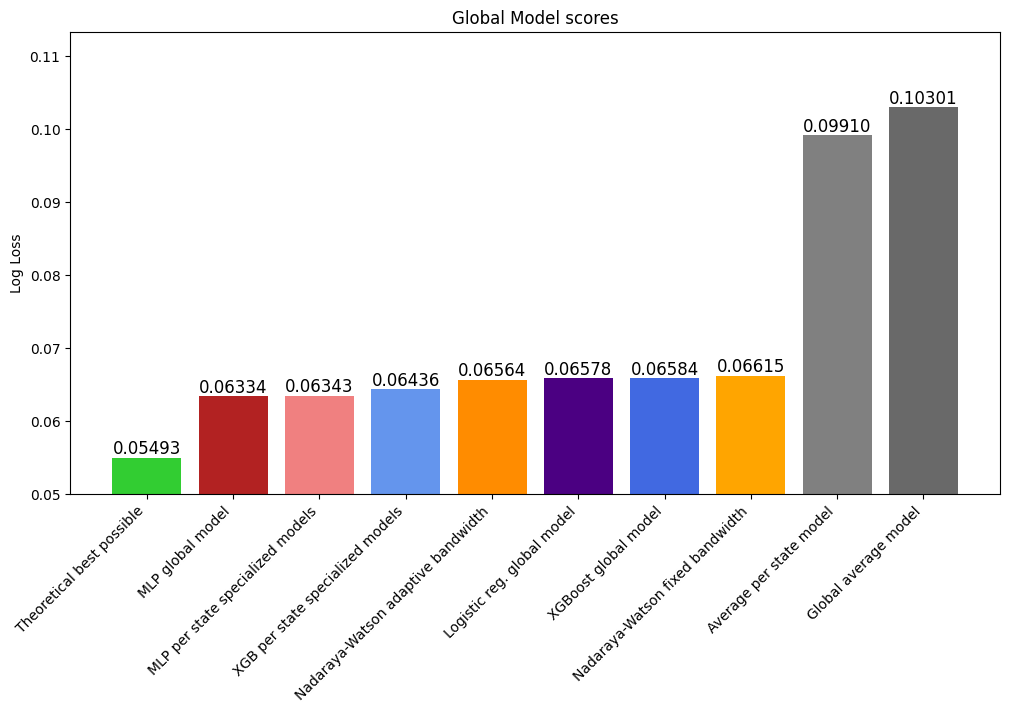

In [167]:
fig, ax = plt.subplots(figsize=(12, 6))
for _, row in global_models.iterrows():
# for model, score in global_models.items():
    model=row['Model']
    score=row['Logloss']
    ax.bar(model, score, color=color_models[model])
    ax.text(model, score, f"{score:.5f}", ha='center', va='bottom', fontsize=12)

ax.set_ylabel("Log Loss")
ax.set_title("Global Model scores")
ax.set_xticklabels(global_models['Model'], rotation=45, ha='right')
ax.set_ylim(0.05, max(global_models['Logloss'])*1.1)
plt.show()

## Per state

In [164]:
scores_state = {"Global average model": global_average_specialized_logloss,
                "MLP per state specialized models": {s:best_mlp_per_state_logloss[s] for s in states},
                "XGB per state specialized models": {s:best_xgb_per_state_logloss[s] for s in states},
                "Logistic reg. global model": global_logistic_specialized_logloss,
                "Theoretical best possible": th_best_specialized_logloss,
                }

In [165]:
states2idx_alph = {s:i for i, s in enumerate(states)}
states2idx_th_perf = {s:i for i, s in enumerate(sorted(th_best_specialized_logloss, key=th_best_specialized_logloss.get))}
states2idx_weight = {s:i for i, s in enumerate(sorted(state_weights, key=state_weights.get, reverse=True))}

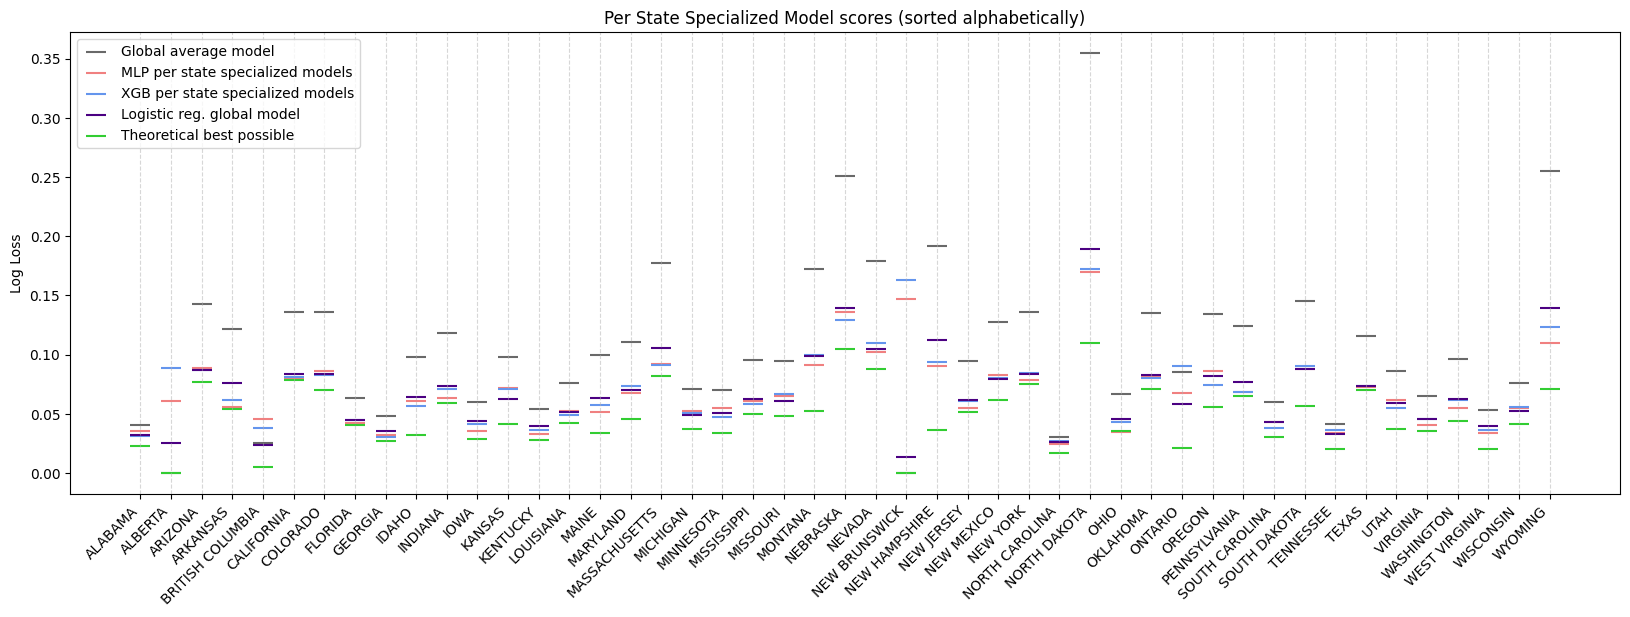

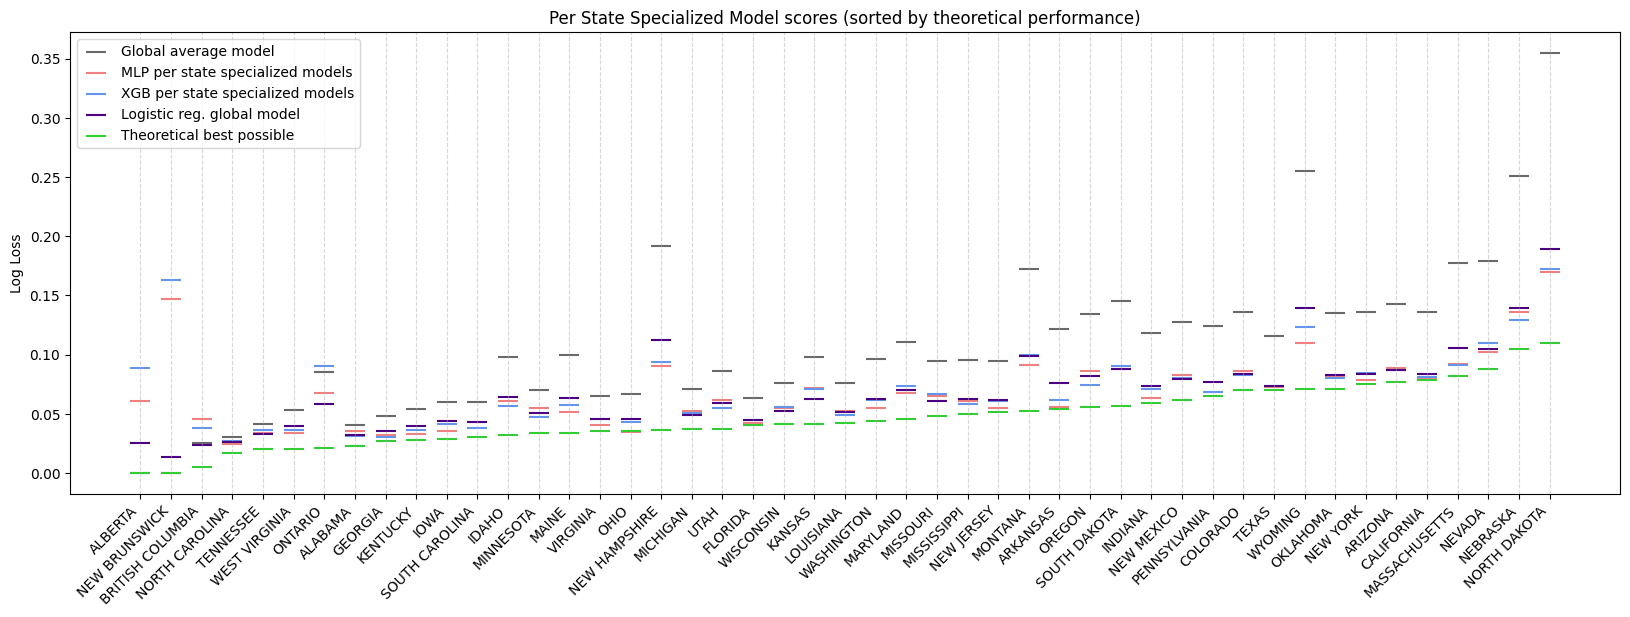

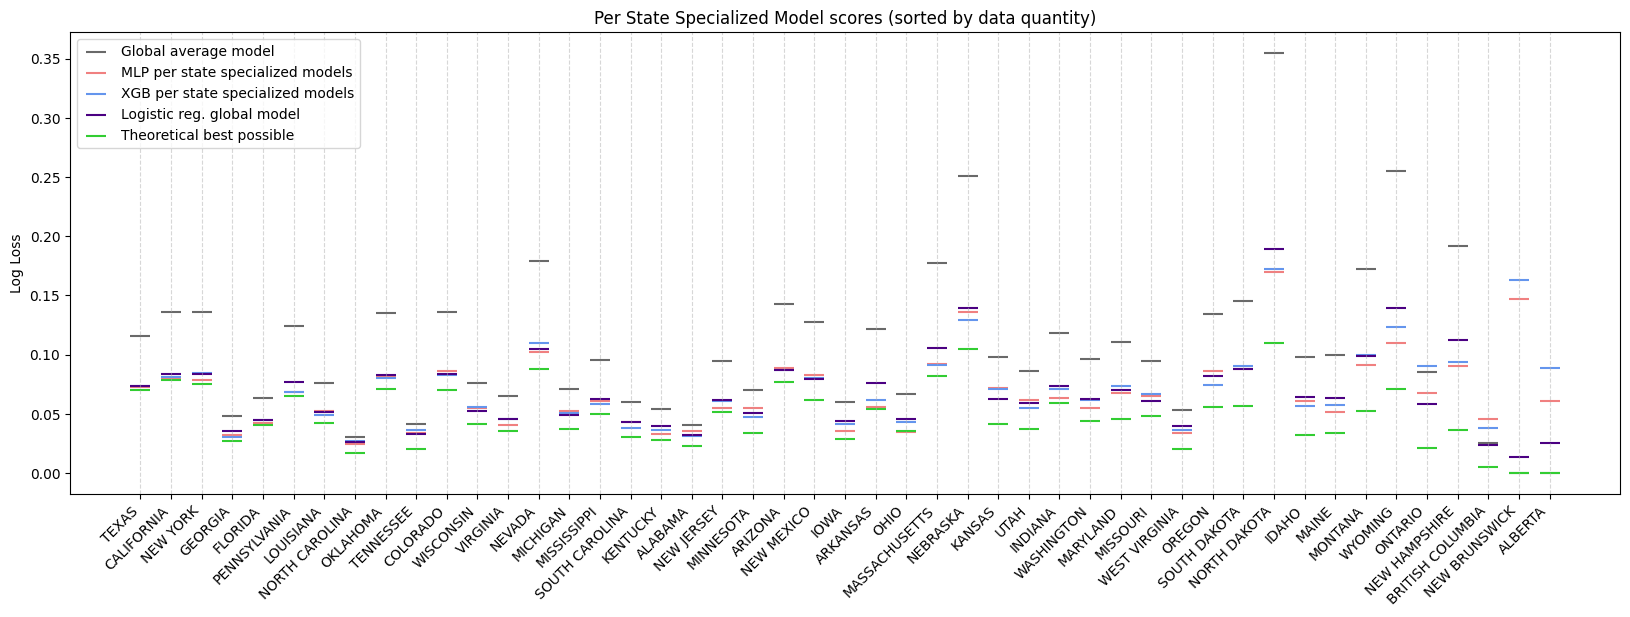

In [166]:
for states2idx, title in zip([states2idx_alph, states2idx_th_perf, states2idx_weight],
                                ["(sorted alphabetically)", "(sorted by theoretical performance)", "(sorted by data quantity)"]):
    fig, ax = plt.subplots(figsize=(20, 6))
    for model, scores_per_state in scores_state.items():
        ax.scatter([states2idx[s] for s in states], [scores_per_state[s] for s in states], label=model, marker='_', s=200, color=color_models[model])

    ax.set_ylabel("Log Loss")
    ax.set_title(f"Per State Specialized Model scores {title}")
    ax.set_xticks([states2idx[s] for s in states])
    ax.set_xticklabels(states, rotation=45, ha='right')
    ax.legend(loc='upper left')

    # Add vertical grid lines
    ax.xaxis.grid(True, which='major', linestyle='--', alpha=0.5)

    plt.show()

